# Experiment

In [1]:
import pandas as pd
import numpy as np
import torch
import os
from IPython.display import display
import matplotlib.pyplot as plt

from models import get_global_threshold, get_individual_thresholds
from models import get_global_similarity_log_reg, get_similarity_log_reg
from models import get_embeddings_log_reg
from models import get_global_sim_X_y, get_concept_sim_X_y

from calibration_framework import apply_platt_scaling, apply_isotonic_regression, apply_temperature_scaling
from calibration_framework import apply_histogram_binning, apply_beta_calibration
from calibration_framework import apply_platt_scaling_v2, apply_temperature_scaling_v2

from utils import compare_all_models_calibration_metric, compare_all_models_calibration_avg, compare_all_models_calibration_concept

In [2]:
dataset_name = 'true-false-dataset'

## 1. Get pre-processed data

In [3]:
metadata_df = pd.read_csv(f'../Data/{dataset_name}/metadata.csv')
embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')
cosine_similarity_df = pd.read_csv(f'Cosine_Similarities/{dataset_name}/train_cosine_similarities.csv')

if dataset_name == 'CLEVR':
    metadata_df = metadata_df.drop(['size::large','material::rubber'], axis=1)
    cosine_similarity_df = cosine_similarity_df.drop(['size::large','material::rubber'], axis=1)

concepts = list(cosine_similarity_df.columns)

train_mask = metadata_df['split'] == 'train'
train_embeddings = embeddings[train_mask]
train_metadata_df = metadata_df[train_mask].reset_index(drop=True)
train_cosine_similarity_df = cosine_similarity_df[train_mask].reset_index(drop=True)

cal_mask = metadata_df['split'] == 'calibration'
cal_embeddings = embeddings[cal_mask]
cal_metadata_df = metadata_df[cal_mask].reset_index(drop=True)
cal_cosine_similarity_df = cosine_similarity_df[cal_mask].reset_index(drop=True)

test_mask = metadata_df['split'] == 'test'
test_embeddings = embeddings[test_mask]
test_metadata_df = metadata_df[test_mask].reset_index(drop=True)
test_cosine_similarity_df = cosine_similarity_df[test_mask].reset_index(drop=True)

/tmp/ipykernel_464759/4219724837.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings = torch.load(f'Embeddings/{dataset_name}/embeddings.pt')


In [4]:
embeddings.shape

torch.Size([6330, 4096])

In [5]:
cosine_similarity_df.shape

(6330, 8)

## 2. Train models

### (GT) Global Threshold

In [6]:
m1_models, m1_global_train_error, m1_train_errors = get_global_threshold(train_metadata_df, train_cosine_similarity_df,
                                                                        verbose=False)
m1_train_errors['Model'] = 'GT'

### (CT) Concept Threshold

In [7]:
m2_models, m2_train_errors = get_individual_thresholds(train_metadata_df, train_cosine_similarity_df, verbose=False)
m2_train_errors['Model'] = 'CT'

### (GLR) Global Similarity LogReg

In [8]:
m3_models, m3_global_train_error, m3_train_errors = get_global_similarity_log_reg(train_metadata_df, 
                                                                                  train_cosine_similarity_df,
                                                                                  verbose=False)
m3_train_errors['Model'] = 'GLR'

### (CLR) Concept Similarity LogReg

In [9]:
m4_models, m4_train_errors = get_similarity_log_reg(train_metadata_df, train_cosine_similarity_df, verbose=False)
m4_train_errors['Model'] = 'CLR'

### (EmbCLR) Embeddings Concept LogReg

In [10]:
m5_models, m5_train_errors = get_embeddings_log_reg(train_embeddings, train_metadata_df, train_cosine_similarity_df,
                                                   verbose=False)
m5_train_errors['Model'] = 'EmbCLR'

In [11]:
base_models = {'GT': m1_models,
               'CT': m2_models,
               'GLR': m3_models,
               'CLR': m4_models,
               'EmbCLR': m5_models
         }

### 2.1 Evaluate training classification error

In [12]:
error_comparison_df = pd.DataFrame.from_dict([m1_train_errors, 
                                              m2_train_errors,
                                              m3_train_errors,
                                              m4_train_errors,
                                              m5_train_errors
                                             ])
error_comparison_df = error_comparison_df.set_index('Model')
if dataset_name == 'CUB':
    error_comparison_df = error_comparison_df.transpose()
    display(error_comparison_df.describe())
else:
    display(error_comparison_df)

,true,animals,cities,companies,elements,facts,generated,inventions
Model,,,,,,,,
GT,0.489898,0.017318,0.087641,0.070060,0.008922,0.118342,0.155077,0.070585
CT,0.498819,0.017318,0.079507,0.016531,0.006822,0.092102,0.042771,0.063500
GLR,0.499082,0.023353,0.124114,0.126214,0.015219,0.092627,0.125689,0.101548
CLR,0.520073,0.019155,0.082131,0.025453,0.009709,0.096300,0.042771,0.134086
EmbCLR,0.001050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## 3. Calibrate models

In [13]:
X_cal, y_cal, _, _ = get_global_sim_X_y(cal_metadata_df, cal_cosine_similarity_df)

m3_models_cal = {}

m3_models_cal['Platt'] = apply_platt_scaling(m3_models, X_cal, y_cal)
m3_models_cal['Isotonic'] = apply_isotonic_regression(m3_models, X_cal, y_cal)
m3_models_cal['Temperature'] = apply_temperature_scaling(m3_models, X_cal, y_cal, verbose=False)

m3_models_cal['Platt v2'] = apply_platt_scaling_v2(m3_models, X_cal, y_cal)
m3_models_cal['Temperature v2'] = apply_temperature_scaling_v2(m3_models, X_cal, y_cal)

In [14]:
m3_models_cal['Histogram'] = apply_histogram_binning(m3_models, X_cal, y_cal, nbins=10)
m3_models_cal['Beta'] = apply_beta_calibration(m3_models, X_cal, y_cal)

In [15]:
m4_models_cal = {}
m4_models_cal['Platt'] = {}
m4_models_cal['Isotonic'] = {}
m4_models_cal['Temperature'] = {}

m4_models_cal['Platt v2'] = {}
m4_models_cal['Temperature v2'] = {}

m4_models_cal['Histogram'] = {}
m4_models_cal['Beta'] = {}

for concept in m4_models.keys():
    X_cal, y_cal = get_concept_sim_X_y(cal_metadata_df, cal_cosine_similarity_df, concept)

    m4_models_cal['Platt'][concept] = apply_platt_scaling(m4_models[concept], X_cal, y_cal)
    m4_models_cal['Isotonic'][concept] = apply_isotonic_regression(m4_models[concept], X_cal, y_cal)
    m4_models_cal['Temperature'][concept] = apply_temperature_scaling(m4_models[concept], X_cal, y_cal, verbose=False)
    
    m4_models_cal['Platt v2'][concept] = apply_platt_scaling_v2(m4_models[concept], X_cal, y_cal)
    m4_models_cal['Temperature v2'][concept] = apply_temperature_scaling_v2(m4_models[concept], X_cal, y_cal)
    
    m4_models_cal['Histogram'][concept] = apply_histogram_binning(m4_models[concept], X_cal, y_cal, nbins=10)
    m4_models_cal['Beta'][concept] = apply_beta_calibration(m4_models[concept], X_cal, y_cal)

In [16]:
m5_models_cal = {}
m5_models_cal['Platt'] = {}
m5_models_cal['Isotonic'] = {}
m5_models_cal['Temperature'] = {}

m5_models_cal['Platt v2'] = {}
m5_models_cal['Temperature v2'] = {}

m5_models_cal['Histogram'] = {}
m5_models_cal['Beta'] = {}

for concept in m5_models.keys():
    X_cal = cal_embeddings
    y_cal = (cal_metadata_df[concept]==1).to_numpy().astype(int)

    m5_models_cal['Platt'][concept] = apply_platt_scaling(m5_models[concept], X_cal, y_cal)
    m5_models_cal['Isotonic'][concept] = apply_isotonic_regression(m5_models[concept], X_cal, y_cal)
    m5_models_cal['Temperature'][concept] = apply_temperature_scaling(m5_models[concept], X_cal, y_cal, verbose=False)
    
    m5_models_cal['Platt v2'][concept] = apply_platt_scaling_v2(m5_models[concept], X_cal, y_cal)
    m5_models_cal['Temperature v2'][concept] = apply_temperature_scaling_v2(m5_models[concept], X_cal, y_cal)
    
    m5_models_cal['Histogram'][concept] = apply_histogram_binning(m5_models[concept], X_cal, y_cal, nbins=10)
    m5_models_cal['Beta'][concept] = apply_beta_calibration(m5_models[concept], X_cal, y_cal)

In [17]:
calibrated_models = {'GLR': m3_models_cal,
                     'CLR': m4_models_cal,
                     'EmbCLR': m5_models_cal
                    }

## 4. Evaluate models

In [18]:
results_path = f"Results/{dataset_name}/"
os.makedirs(results_path, exist_ok=True)

### 4.1 Get a single metric for all models, calibration methods, and concepts

**Use only if you don't have many concepts!**

In [19]:
metric = 'K1'

if len(concepts) <= 10:
    metric_df = compare_all_models_calibration_metric(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                       test_metadata_df, test_cosine_similarity_df, test_embeddings, 
                                       metric=metric)
    if not 'K' in metric:
        display(metric_df.style.highlight_max(color='grey'))
    else:
        display(metric_df)

true   animals    cities companies  elements  \
Model  Calibration                                                        
GT     None                   -         -         -         -         -   
CT     None                   -         -         -         -         -   
GLR    None            0.229839  0.146932  0.149204  0.147255  0.110276   
       Histogram       0.246948  0.101442  0.086828  0.123924  0.068297   
       Isotonic        0.236916  0.095887  0.080483  0.120872  0.063072   
       Platt           0.219697   0.15222  0.151411  0.145371  0.114159   
       Platt v2        0.220462  0.152093  0.151392  0.145236  0.114002   
       Temperature     0.107789  0.316571  0.243534  0.318975  0.312506   
       Temperature v2  0.223895  0.153243  0.152769  0.146592  0.115998   
       Beta             0.25847  0.095957    0.0903  0.127742  0.073934   
CLR    None            0.018301  0.077029  0.183155  0.093627  0.052501   
       Histogram       0.015685  0.008475  0.012171  0.002845  0.004149   
       Isotonic        0.037596  0.008559  0.007283   0.00678  0.004836   
       Platt           0.017173   0.01035  0.179099  0.019405  0.007289   
       Platt v2        0.017183   0.00943  0.178485  0.014508  0.004361   
       Temperature     0.015714  0.289417  0.264758  0.290647  0.287433   
       Temperature v2  0.000398  0.017334  0.180339  0.030641  0.009193   
       Beta            0.014661  0.010769  0.107382  0.009605  0.004921   
EmbCLR None            0.111924  0.001575  0.000037   0.00051  0.000768   
       Histogram       0.034483  0.001392       0.0  0.000517       0.0   
       Isotonic        0.035581  0.000976  0.000034  0.000459  0.000348   
       Platt           0.028539  0.004296  0.002626  0.002457  0.002907   
       Platt v2        0.028901  0.001067       0.0  0.000588  0.000493   
       Temperature     0.167374  0.269665  0.268956   0.26918  0.268167   
       Temperature v2  0.029046   0.00151       0.0  0.000586   0.00059   
       Beta            0.031786  0.000866  0.000001  0.000539  0.000416   

                          facts generated inventions  
Model  Calibration                                    
GT     None                   -         -          -  
CT     None                   -         -          -  
GLR    None            0.122963  0.183764   0.110847  
       Histogram       0.122639   0.18366    0.03657  
       Isotonic        0.119236  0.183435   0.039423  
       Platt           0.133025  0.191974   0.117681  
       Platt v2        0.133036  0.191995   0.117485  
       Temperature     0.274666  0.334409   0.250774  
       Temperature v2  0.128861  0.188837   0.116779  
       Beta            0.102079   0.19194   0.048911  
CLR    None            0.022452  0.014688   0.103214  
       Histogram       0.013744  0.008576   0.009926  
       Isotonic        0.015351  0.014638   0.013826  
       Platt            0.02969  0.009535   0.090525  
       Platt v2        0.028466  0.009562   0.089714  
       Temperature     0.217102  0.257594   0.261504  
       Temperature v2  0.022571  0.006591   0.095554  
       Beta            0.019219  0.009571   0.036829  
EmbCLR None            0.002128  0.003372   0.001776  
       Histogram       0.002229  0.002905    0.00187  
       Isotonic        0.000601  0.002674    0.00143  
       Platt           0.006133   0.00459   0.003131  
       Platt v2        0.003697   0.00242   0.001469  
       Temperature       0.2691  0.268211   0.267519  
       Temperature v2  0.003852  0.003821   0.001775  
       Beta            0.003366  0.002747   0.001469

### 4.2 Get the average of all metrics over the concepts for all models and calibration methods

In [20]:
metrics_avg_df = compare_all_models_calibration_avg(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                   test_metadata_df, test_cosine_similarity_df, test_embeddings)
metrics_avg_df.to_csv(os.path.join(results_path, 'metrics_average.csv'))
with open(os.path.join(results_path, 'metrics_average.tex'), 'w') as tf:
     tf.write(metrics_avg_df.to_latex())

with open(os.path.join(results_path, 'metrics_average_short.tex'), 'w') as tf:
     tf.write(metrics_avg_df[['Acc','K1','Kmax']].to_latex())
    
metrics_avg_df#.style.highlight_max(color='grey', subset=['Acc','F1','AUC'])

Acc           F1          AUC           K1  \
Model  Calibration                                                          
GT     None            0.87 ± 0.15  0.60 ± 0.32            -            -   
CT     None            0.90 ± 0.16  0.64 ± 0.38            -            -   
GLR    None            0.86 ± 0.15  0.47 ± 0.34  0.81 ± 0.17  0.15 ± 0.04   
       Histogram       0.87 ± 0.15  0.60 ± 0.32  0.81 ± 0.17  0.12 ± 0.07   
       Isotonic        0.87 ± 0.15  0.59 ± 0.32  0.82 ± 0.17  0.12 ± 0.06   
       Platt           0.86 ± 0.15  0.49 ± 0.33  0.81 ± 0.17  0.15 ± 0.04   
       Platt v2        0.86 ± 0.15  0.49 ± 0.33  0.81 ± 0.17  0.15 ± 0.04   
       Temperature     0.86 ± 0.15  0.47 ± 0.34  0.81 ± 0.17  0.27 ± 0.07   
       Temperature v2  0.86 ± 0.15  0.47 ± 0.34  0.81 ± 0.17  0.15 ± 0.04   
       Beta            0.87 ± 0.15  0.56 ± 0.32  0.81 ± 0.17  0.12 ± 0.07   
CLR    None            0.89 ± 0.17  0.51 ± 0.44  0.81 ± 0.18  0.07 ± 0.06   
       Histogram       0.90 ± 0.16  0.64 ± 0.36  0.80 ± 0.21  0.01 ± 0.00   
       Isotonic        0.90 ± 0.17  0.65 ± 0.35  0.83 ± 0.17  0.01 ± 0.01   
       Platt           0.89 ± 0.16  0.60 ± 0.41  0.81 ± 0.17  0.05 ± 0.06   
       Platt v2        0.89 ± 0.16  0.61 ± 0.41  0.81 ± 0.17  0.04 ± 0.06   
       Temperature     0.89 ± 0.17  0.51 ± 0.44  0.81 ± 0.18  0.24 ± 0.09   
       Temperature v2  0.89 ± 0.16  0.46 ± 0.48  0.81 ± 0.18  0.05 ± 0.06   
       Beta            0.90 ± 0.16  0.63 ± 0.39  0.81 ± 0.18  0.03 ± 0.03   
EmbCLR None            0.98 ± 0.05  0.97 ± 0.05  0.99 ± 0.02  0.02 ± 0.04   
       Histogram       0.98 ± 0.05  0.97 ± 0.05  0.98 ± 0.04  0.01 ± 0.01   
       Isotonic        0.98 ± 0.05  0.97 ± 0.05  0.99 ± 0.02  0.01 ± 0.01   
       Platt           0.98 ± 0.05  0.97 ± 0.05  0.99 ± 0.02  0.01 ± 0.01   
       Platt v2        0.98 ± 0.05  0.98 ± 0.05  0.99 ± 0.02  0.00 ± 0.01   
       Temperature     0.98 ± 0.05  0.97 ± 0.05  0.99 ± 0.02  0.26 ± 0.04   
       Temperature v2  0.98 ± 0.05  0.97 ± 0.05  0.99 ± 0.02  0.01 ± 0.01   
       Beta            0.98 ± 0.05  0.97 ± 0.05  0.99 ± 0.02  0.01 ± 0.01   

                                K2         Kmax  
Model  Calibration                               
GT     None                      -            -  
CT     None                      -            -  
GLR    None            0.04 ± 0.02  0.05 ± 0.02  
       Histogram       0.03 ± 0.03  0.05 ± 0.04  
       Isotonic        0.03 ± 0.03  0.05 ± 0.04  
       Platt           0.04 ± 0.02  0.05 ± 0.02  
       Platt v2        0.04 ± 0.02  0.05 ± 0.02  
       Temperature     0.08 ± 0.03  0.13 ± 0.04  
       Temperature v2  0.04 ± 0.02  0.05 ± 0.02  
       Beta            0.04 ± 0.03  0.05 ± 0.03  
CLR    None            0.01 ± 0.01  0.02 ± 0.01  
       Histogram       0.00 ± 0.00  0.01 ± 0.00  
       Isotonic        0.00 ± 0.00  0.01 ± 0.01  
       Platt           0.01 ± 0.01  0.02 ± 0.01  
       Platt v2        0.01 ± 0.01  0.01 ± 0.02  
       Temperature     0.07 ± 0.03  0.15 ± 0.07  
       Temperature v2  0.01 ± 0.02  0.01 ± 0.02  
       Beta            0.00 ± 0.00  0.01 ± 0.01  
EmbCLR None            0.00 ± 0.01  0.01 ± 0.02  
       Histogram       0.00 ± 0.00  0.00 ± 0.00  
       Isotonic        0.00 ± 0.00  0.00 ± 0.00  
       Platt           0.00 ± 0.00  0.00 ± 0.00  
       Platt v2        0.00 ± 0.00  0.00 ± 0.00  
       Temperature     0.07 ± 0.02  0.21 ± 0.06  
       Temperature v2  0.00 ± 0.00  0.00 ± 0.00  
       Beta            0.00 ± 0.00  0.00 ± 0.00

### 4.3 Get all metrics for all models and calibration methods for a single concept

In [21]:
concept = concepts[0]

metrics_concept_df = compare_all_models_calibration_concept(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                   test_metadata_df, test_cosine_similarity_df, test_embeddings,
                                   concept=concept)
metrics_concept_df.to_csv(os.path.join(results_path, f'metrics_concept_{concept}.csv'))
with open(os.path.join(results_path, f'metrics_concept_{concept}.tex'), 'w') as tf:
     tf.write(metrics_concept_df.to_latex())

In [22]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values[s.values != '-']), props, '')
tmp = metrics_concept_df.style.apply(highlight_min, props='background-color:grey;', subset=['K1', 'K2', 'Kmax'])
tmp.highlight_max(color='grey', subset=['Acc','F1','AUC'])

In [23]:
if len(concepts) < 10:
    for concept in concepts:
        metrics_concept_df = compare_all_models_calibration_concept(base_models, m3_models_cal, m4_models_cal, m5_models_cal,
                                           test_metadata_df, test_cosine_similarity_df, test_embeddings,
                                           concept=concept)
        metrics_concept_df.to_csv(os.path.join(results_path, f'metrics_concept_{concept}.csv'))
        with open(os.path.join(results_path, f'metrics_concept_{concept}.tex'), 'w') as tf:
             tf.write(metrics_concept_df.to_latex())

## 5. Calibration curves

### a) Calibration error

In [24]:
from calibration import plot_calibration_curves_concept, plot_calibration_curves_avg, plot_calibrators

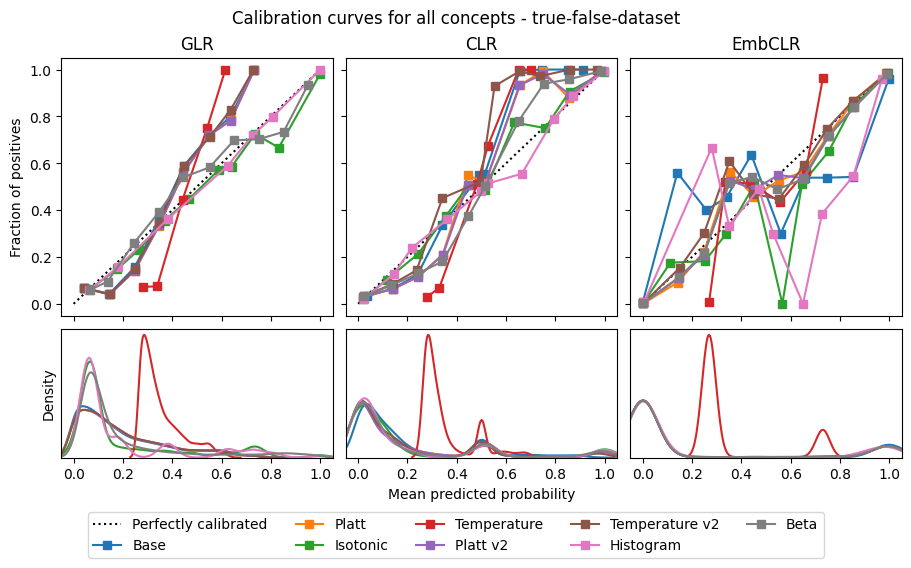

In [25]:
fig = plot_calibration_curves_avg(test_metadata_df, test_cosine_similarity_df, 
                                  test_embeddings, base_models, calibrated_models,
                                  results_path, dataset_name)

/tmp/ipykernel_464759/3639167923.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_464759/3639167923.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_464759/3639167923.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_464759/3639167923.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_464759/3639167923.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_464759/3639167923.py

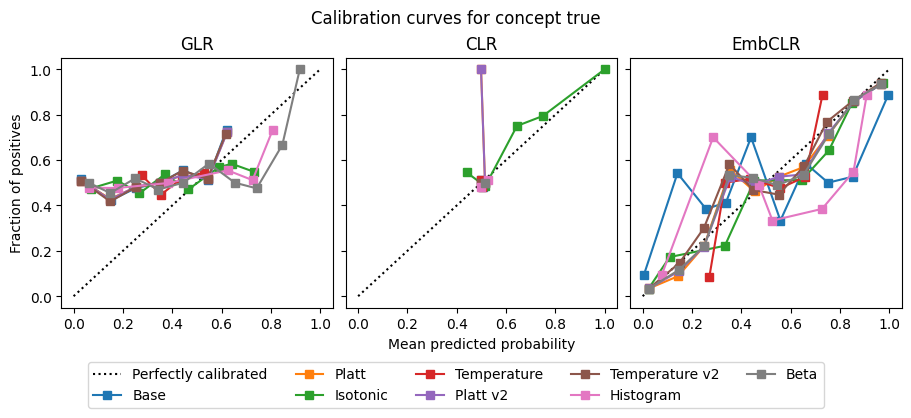

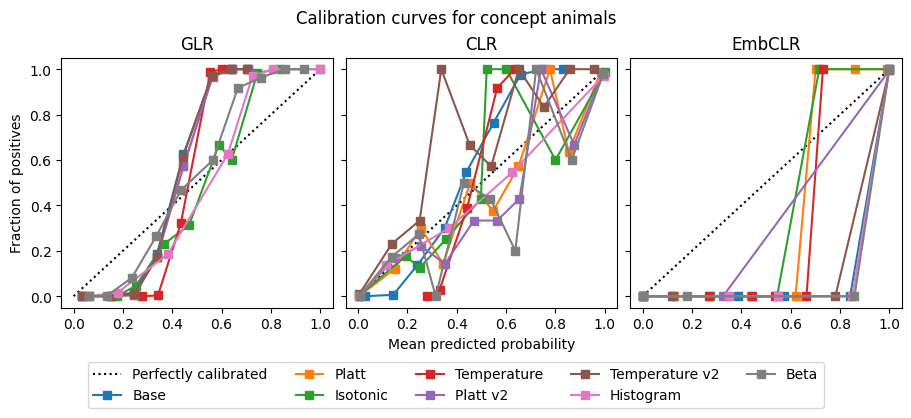

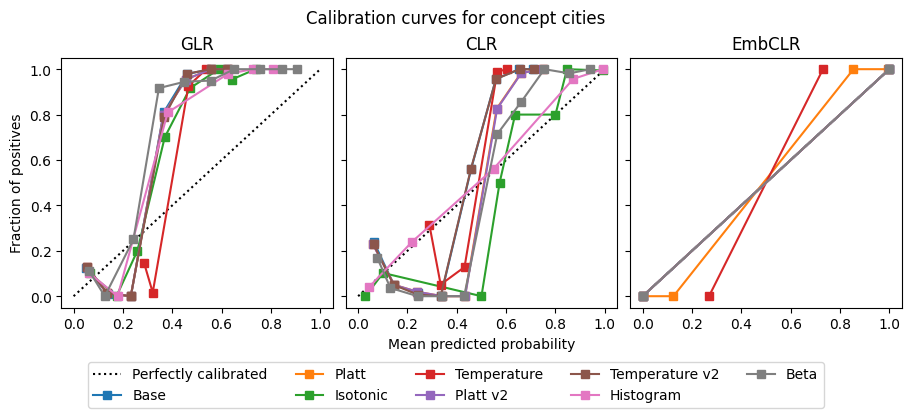

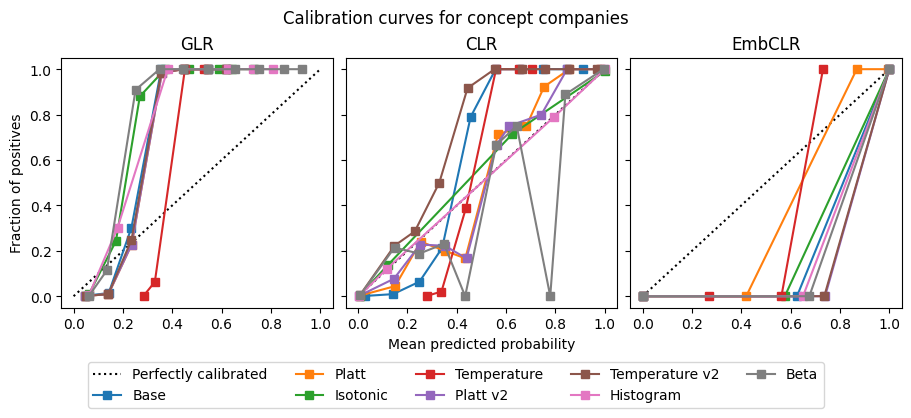

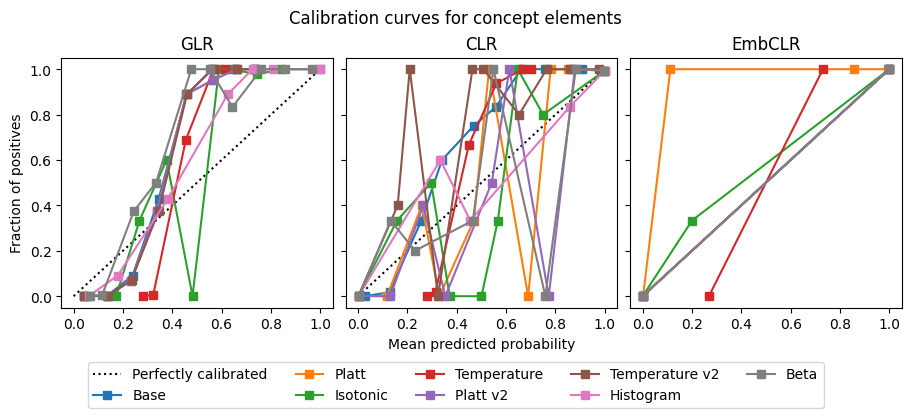

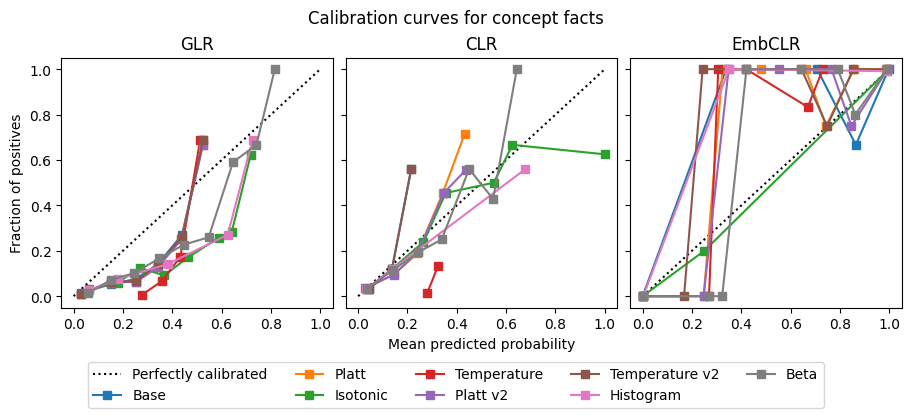

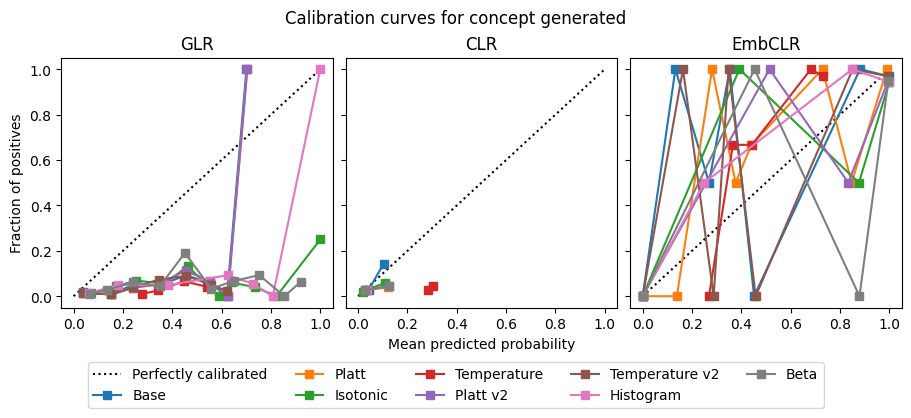

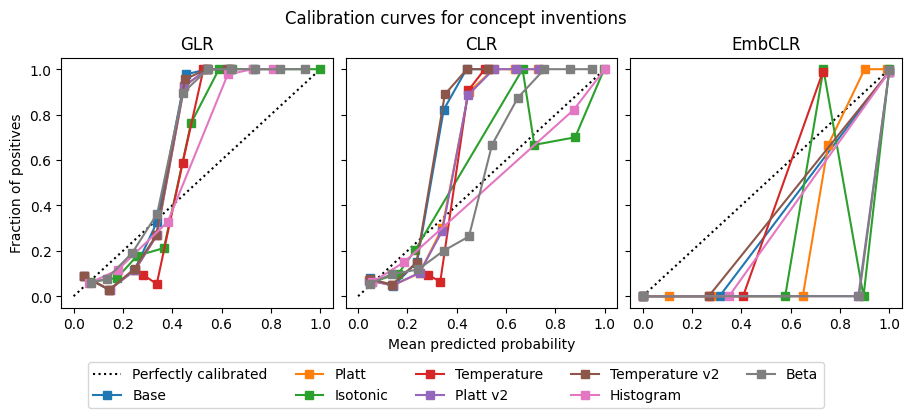

In [26]:
if len(concepts) < 10:
    for concept in concepts:
        fig = plot_calibration_curves_concept(test_metadata_df, test_cosine_similarity_df, 
                                            test_embeddings, base_models, calibrated_models,
                                            concept, results_path)
        fig.show()
else:
    for concept in concepts[:10]:
        fig = plot_calibration_curves_concept(test_metadata_df, test_cosine_similarity_df, 
                                            test_embeddings, base_models, calibrated_models,
                                            concept, results_path)
        fig.show()

### b) Calibration functions

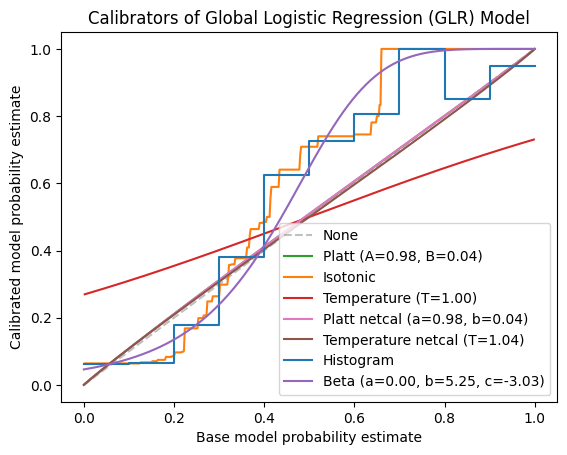

In [27]:
plot_calibrators(calibrated_models['GLR'], 'Global Logistic Regression (GLR)', concept = None, path = None)

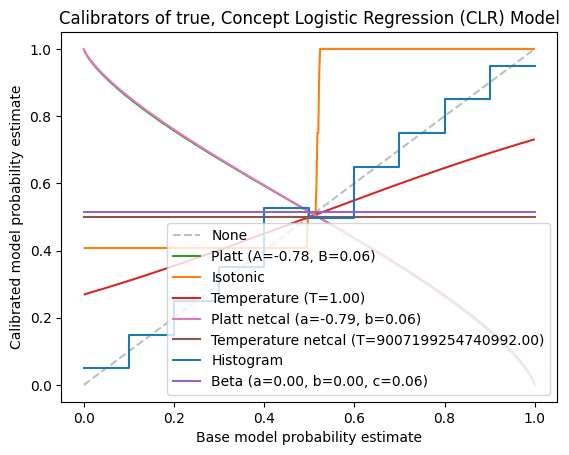

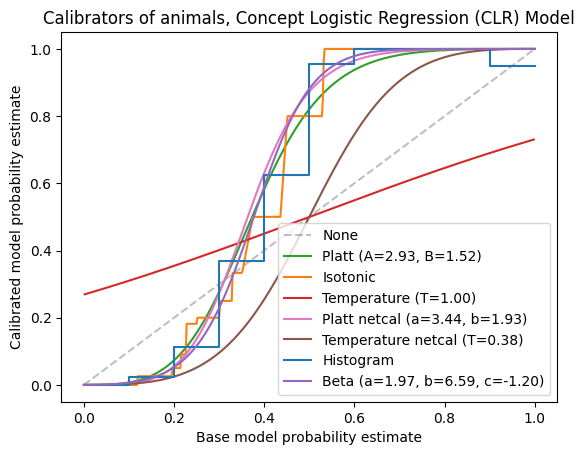

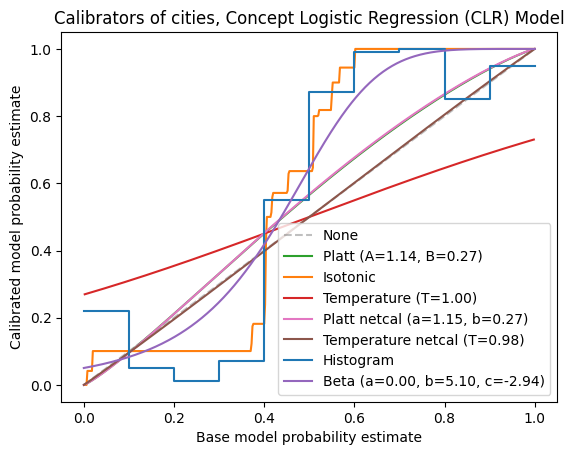

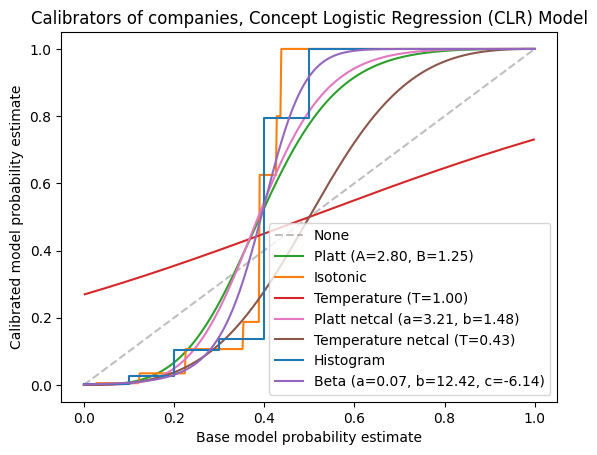

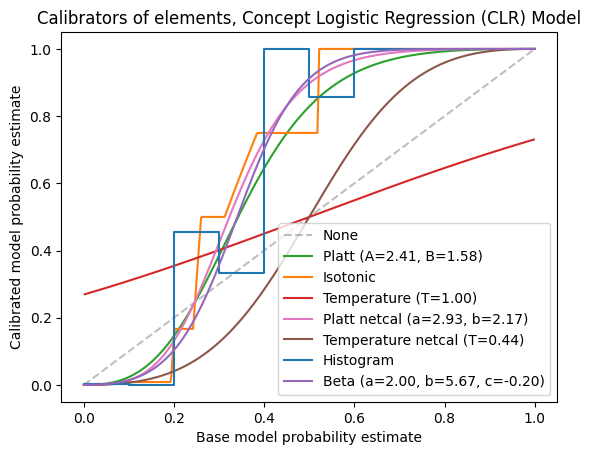

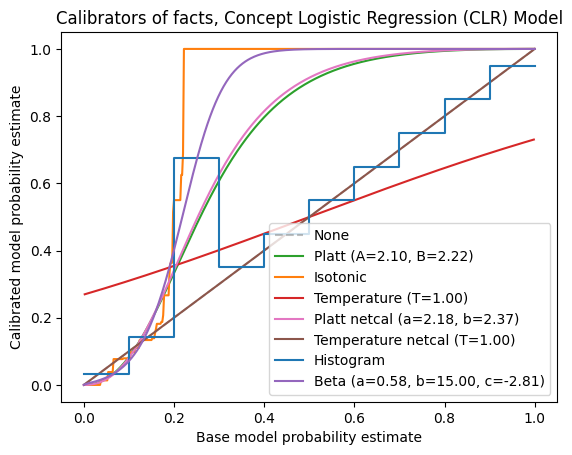

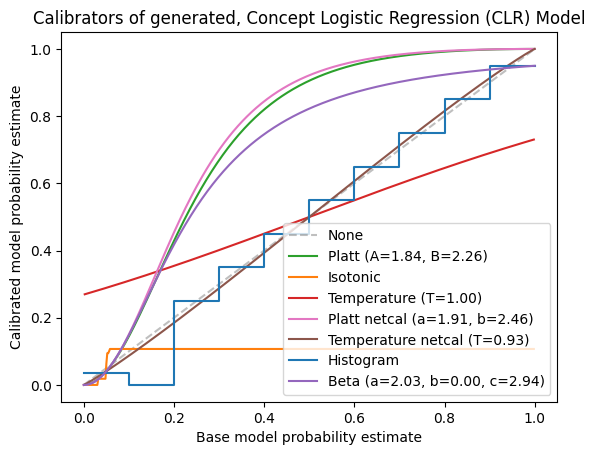

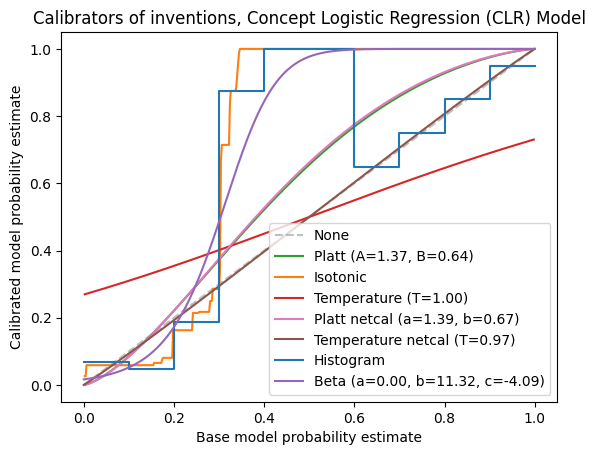

In [28]:
for concept in concepts[:min(10, len(concepts))]:
    plot_calibrators(calibrated_models['CLR'], '{}, Concept Logistic Regression (CLR)'.format(concept), concept = concept, path = None)

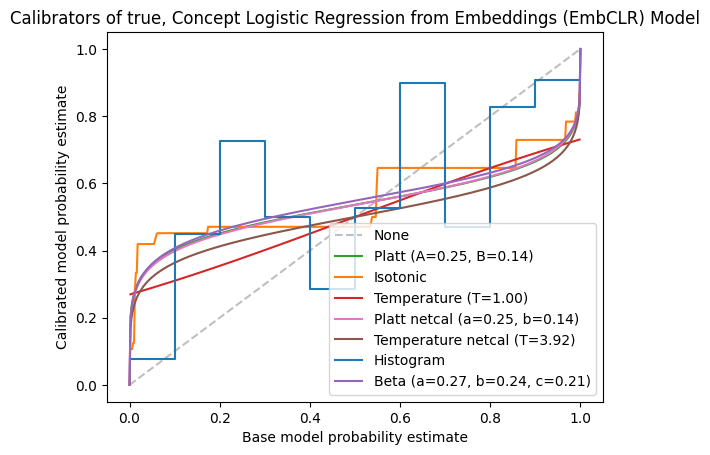

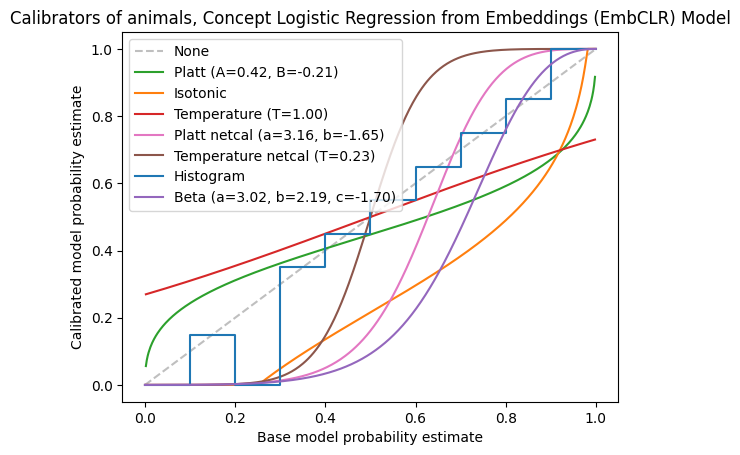

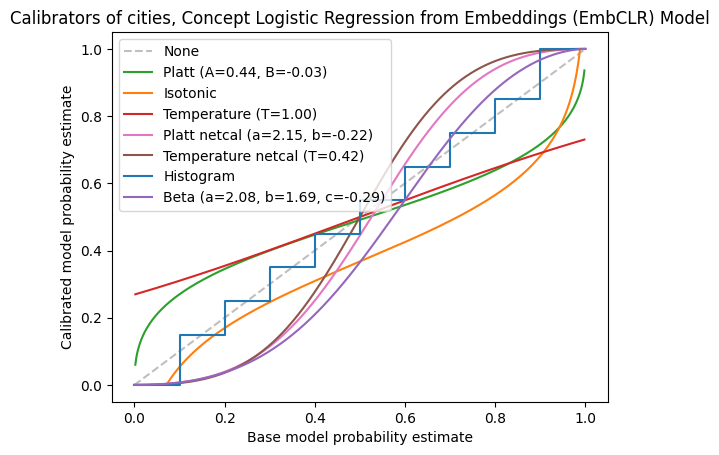

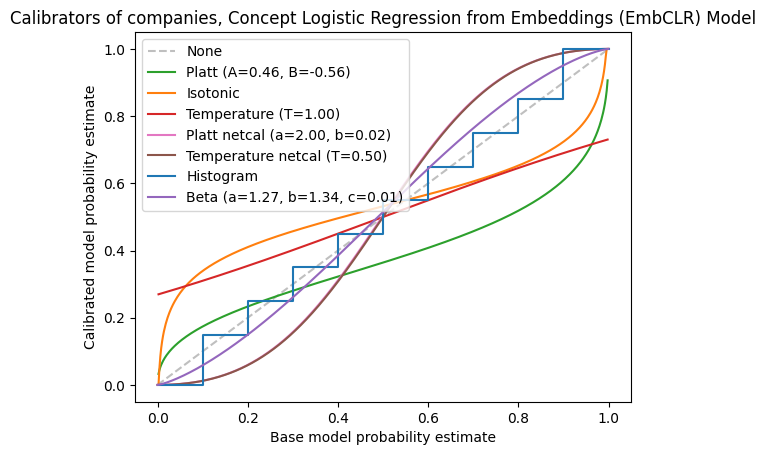

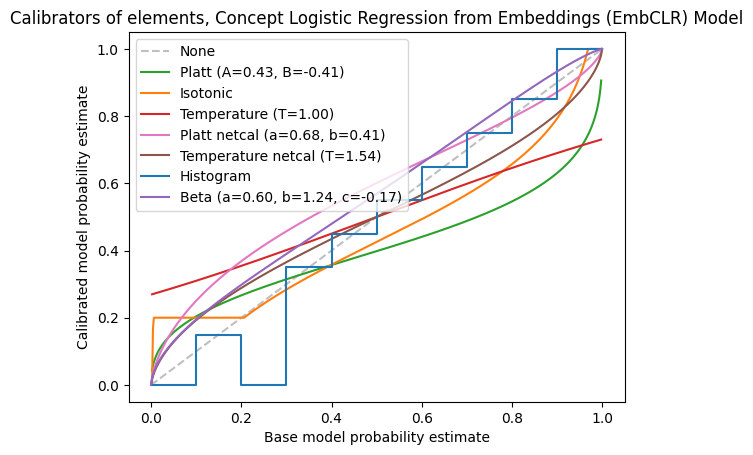

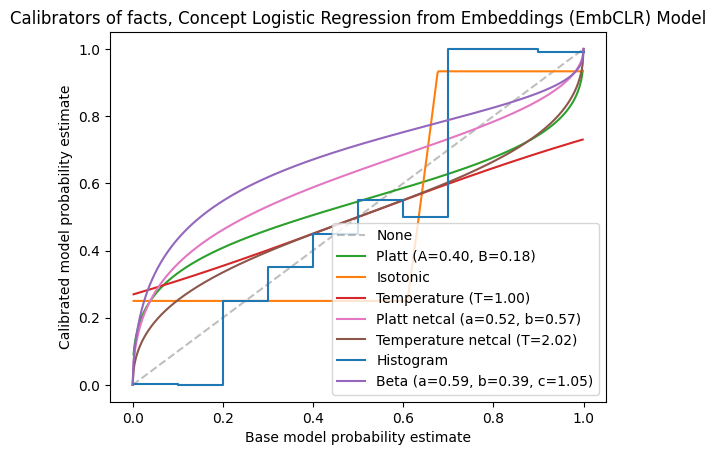

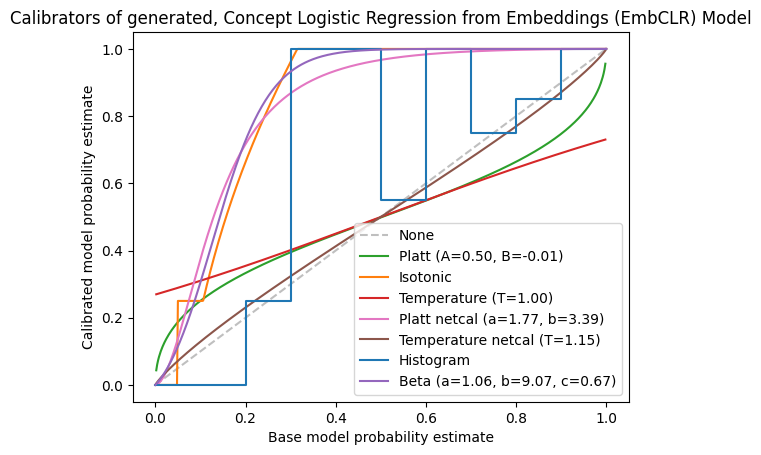

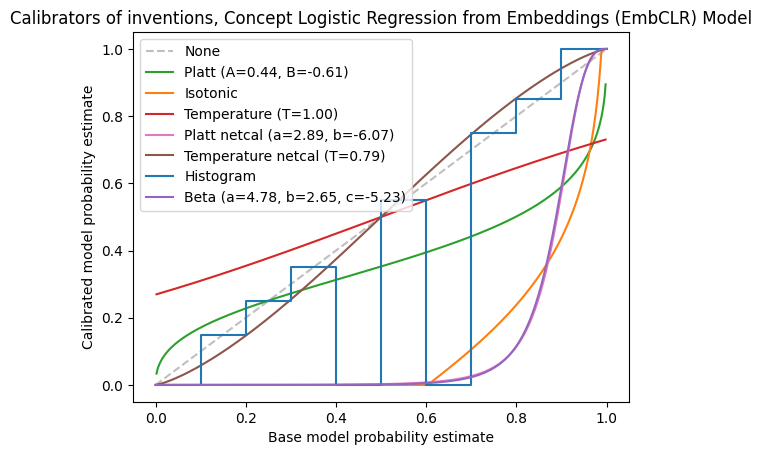

In [29]:
for concept in concepts[:min(10, len(concepts))]:
    plot_calibrators(calibrated_models['EmbCLR'], '{}, Concept Logistic Regression from Embeddings (EmbCLR)'.format(concept), concept = concept, path = None)

## Old stuff

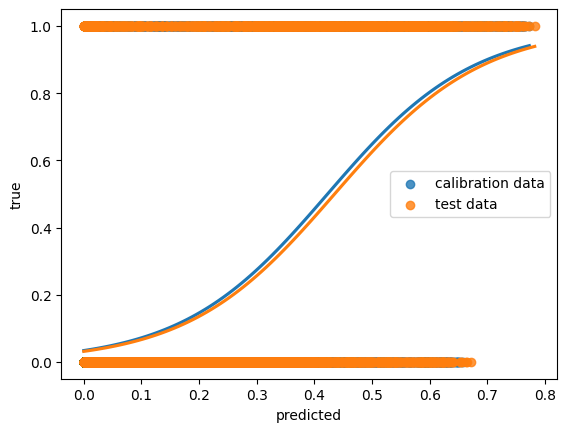

In [36]:
model = m3_models_cal['Platt v2']

X_cal, y_cal, _, _ = get_global_sim_X_y(cal_metadata_df, cal_cosine_similarity_df)
da_cal = pd.DataFrame.from_dict({'predicted' : m3_models.predict_proba(X_cal)[:, 1], 'true' : y_cal})

X_test, y_test, _, _ = get_global_sim_X_y(test_metadata_df, test_cosine_similarity_df)
da_test = pd.DataFrame.from_dict({'predicted' : m3_models.predict_proba(X_test)[:, 1], 'true' : y_test})

import seaborn as sns
sns.regplot(x='predicted', y='true', data = da_cal, logistic=True, ci = None, label = 'calibration data')
sns.regplot(x='predicted', y='true', data = da_test, logistic=True, ci = None, label = 'test data')

plt.legend()

# CLEVR -- uncalibrated model has total separation on the calibration set, that's not good (or is it?)

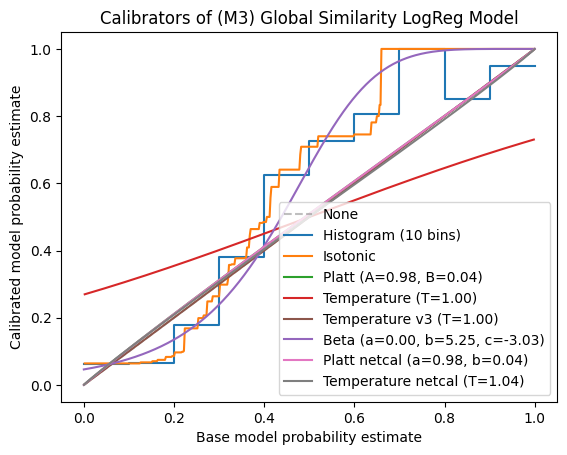

In [37]:
from scipy.special import logit, expit
from matplotlib import pyplot as plt
fig, ax = plt.subplots()

n = 501 # discretization
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# None
plt.plot([0, 1], [0, 1], label = 'None', color = 'grey', linestyle = 'dashed', alpha = 0.5)

# Histogram binning
x_vals = m3_models_cal['Histogram'].calibrator.get_params()['_bin_bounds'][0]
y_vals = m3_models_cal['Histogram'].calibrator.get_params()['_bin_map']
y_vals = np.append(y_vals, y_vals[-1])
nbins = m3_models_cal['Histogram'].calibrator.get_params()['bins']
plt.step(x_vals, y_vals, where = 'post', label = 'Histogram ({} bins)'.format(nbins), color = colors[0])

# Isotonic regression (would be nice if I could find the true bins but this will do)
x_vals = np.linspace(0, 1, num=n, endpoint=True)[1:-1]
y_vals = m3_models_cal['Isotonic'].calibrated_classifiers_[0].calibrators[0].predict(logit(x_vals))
plt.plot(x_vals, y_vals, label = 'Isotonic', color = colors[1])

# Platt scaling
x_vals = np.linspace(0, 1, num=n, endpoint=True)[1:-1]
y_vals = m3_models_cal['Platt'].calibrated_classifiers_[0].calibrators[0].predict(logit(x_vals))
tmp = m3_models_cal['Platt'].calibrated_classifiers_[0].calibrators[0]
a, b = -tmp.a_, -tmp.b_
plt.plot(x_vals, y_vals, label = 'Platt (A={:.2f}, B={:.2f})'.format(a, b), color = colors[2])
#plt.plot(x_vals, expit(a*logit(x_vals) + b), label = 'Platt sanity check', color = 'red')

# Temperature scaling

# This matches what the code currently does on data (softmax and no logit)
tmp = m3_models_cal['Temperature']
T = tmp.temperature
x_vals_vec = np.array([1 - x_vals, x_vals]).T
y_vals = tmp.softmax(x_vals_vec / tmp.temperature)[:, 1]
plt.plot(x_vals, y_vals, label = 'Temperature (T={:.2f})'.format(T), color = colors[3])

# Emma thinks this should be the correct version (it looks way more believable)
T = m3_models_cal['Temperature'].temperature
x_vals = np.linspace(0, 1, num=n, endpoint=True)[1:-1]
y_vals = expit(logit(x_vals) / T)
plt.plot(x_vals, y_vals, label = 'Temperature v3 (T={:.2f})'.format(T), color = colors[5])

# Beta calibration
x_vals = np.linspace(0, 1, num=n, endpoint=True)
y_vals = m3_models_cal['Beta'].calibrator.transform(x_vals)
tmp = m3_models_cal['Beta'].calibrator.get_params()
a, b = tmp['_sites']['weights']['values']
c = tmp['_sites']['bias']['values'][0]
plt.plot(x_vals, y_vals, label = 'Beta (a={:.2f}, b={:.2f}, c={:.2f})'.format(a, b, c), color = colors[4])

## netcal

# Platt scaling v2
x_vals = np.linspace(0, 1, num=n, endpoint=True)
y_vals = m3_models_cal['Platt v2'].calibrator.transform(x_vals)
a = m3_models_cal['Platt v2'].calibrator.weights[0]
b = m3_models_cal['Platt v2'].calibrator.intercept[0]
plt.plot(x_vals, y_vals, label = 'Platt netcal (a={:.2f}, b={:.2f})'.format(a, b), color = colors[6])
#plt.plot(x_vals, expit(a*logit(x_vals) + b), label = 'Platt netcal sanity check', color = 'red')

# Temperature scaling v2
x_vals = np.linspace(0, 1, num=n, endpoint=True)
y_vals = m3_models_cal['Temperature v2'].calibrator.transform(x_vals)
T = 1 / m3_models_cal['Temperature v2'].calibrator.temperature[0]
plt.plot(x_vals, y_vals, label = 'Temperature netcal (T={:.2f})'.format(T), color = colors[7])
#plt.plot(x_vals, expit(logit(x_vals) / T), label = 'Temperature netcal sanity check', color = 'red')

plt.legend()
ax.set_xlabel('Base model probability estimate')
ax.set_ylabel('Calibrated model probability estimate')
ax.set_title('Calibrators of {} Model'.format('(M3) Global Similarity LogReg'))
plt.show()

In [39]:
# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Platt'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Platt from data', s = 6, color = 'purple')

# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Isotonic'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Isotonic from data', s = 6, color = 'red')

# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Temperature'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Temperature from data', s = 6, color = 'violet')

# x_vals = m3_models.predict_proba(X_cal)
# y_vals = m3_models_cal['Beta'].predict_proba(X_cal)
# plt.scatter(x_vals, y_vals, label = 'Beta from data', s = 6, color = 'violet') 
# why are a bunch of these giving me double vision, maybe they're giving probabilities for both true and false labels?

# tmp = m3_models_cal['Beta'].calibrator.get_params()
# a, b = tmp['_sites']['weights']['values']
# c = tmp['_sites']['bias']['values'][0]
# y_vals = np.exp(c) * x_vals**a / (1 - x_vals)**b
# y_vals = 1 / (1 + (1/y_vals))
# plt.plot(x_vals, y_vals, label = 'Beta guess')